In [1]:
import logging
import random
import os
import warnings

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from models import *

warnings.filterwarnings("ignore")

# Make code deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
# Set file paths
BASE_PATH = os.path.join("/home/source/experiments/")
MODEL_BASE_PATH = os.path.join(BASE_PATH, 'exp03_models')

# Set information about the dataset
HDF5_FILE_PATH = os.path.join(os.sep, 'home', 'data', "ANNOTATED_BEDTIME_TU7.hdf5")
COLNAMES = ["Time", "X", "Y", "Z", "Annotated Time in Bed"]
SAMPLE_RATE = 100
LABEL_DICT = {False: 0, True: 1}
EXCLUDED_DATASETS = ["subject90067325"]

# Set information about the model, etc.
INPUT_DIM = 160
OUTPUT_DIM = 1

DROPOUT = 0.5 # https://jmlr.org/papers/v15/srivastava14a.html
BATCH_SIZE = 8

HID_DIM = 16
N_LAYERS = 1

# Minimal required loss impprovement
EPSILON = 1e-4

means = torch.Tensor([ -48.4207,  -65.1218,  -71.5279,  -76.1308,  -79.9645,  -83.3663,
                       -86.4398,  -89.1959,  -91.6206,  -93.0964,  -95.0577,  -97.5050,
                       -98.9434, -100.2508, -101.4559, -101.9244, -103.0111, -104.7183,
                      -105.5989, -105.6751, -106.4759, -107.9065, -108.5371, -108.4562,
                      -109.0211, -110.2759, -110.0502, -110.5009, -111.6296, -111.2670,
                      -111.6191, -111.9629, -112.2249, -113.2178, -112.7033, -112.8654,
                      -113.0358, -113.1333, -113.2129, -113.2895,  -48.2245,  -66.3324,
                       -73.2612,  -77.7942,  -81.1151,  -84.1829,  -86.7018,  -88.9712,
                       -90.9700,  -92.1339,  -93.9986,  -96.3574,  -97.8250,  -99.1140,
                      -100.1279, -100.4639, -101.3244, -103.0022, -103.9505, -104.0372,
                      -104.8954, -106.1583, -106.6984, -106.5298, -106.8966, -108.3447,
                      -108.1104, -108.5275, -109.7666, -109.1461, -109.5073, -109.7905,
                      -109.8520, -111.1019, -110.4769, -110.5905, -110.9061, -110.7892,
                      -110.9209, -111.0517,  -43.2543,  -61.6885,  -68.9491,  -73.5991,
                       -77.1016,  -80.0631,  -82.7077,  -85.1379,  -87.3117,  -88.6311,
                       -90.4376,  -92.7634,  -94.2068,  -95.5118,  -96.7122,  -97.2450,
                       -98.3478, -100.0788, -101.0015, -101.1428, -101.9611, -103.4203,
                      -104.0778, -104.0826, -104.7114, -106.0103, -105.8721, -106.3384,
                      -107.5007, -107.1565, -107.5132, -107.8857, -108.1693, -109.1731,
                      -108.7007, -108.9047, -109.0983, -109.1834, -109.2635, -109.3219,
                       -88.4789,  -95.3224,  -97.4297,  -98.6238,  -99.8170, -101.9552,
                      -103.8918, -105.9195, -107.9017, -109.0472, -110.9086, -113.2247,
                      -114.7520, -116.0630, -117.1561, -117.7766, -118.7566, -120.5036,
                      -121.3769, -121.2272, -122.1442, -123.5198, -124.1882, -124.2786,
                      -124.6115, -126.1393, -125.7334, -126.0776, -127.6043, -126.9575,
                      -127.5121, -127.9141, -127.7025, -129.1585, -128.4213, -128.5968,
                      -129.2008, -129.0018, -129.1680, -129.2950])

stds = torch.Tensor([15.2365, 16.0121, 15.9737, 16.1929, 15.9387, 15.5965, 15.1987, 14.7376,
                     14.3288, 13.9616, 13.6932, 13.4502, 13.2141, 13.0099, 12.8077, 12.6167,
                     12.4420, 12.3011, 12.1666, 11.9817, 11.9137, 11.8341, 11.7676, 11.7024,
                     11.6222, 11.6012, 11.5212, 11.4829, 11.4804, 11.4021, 11.3955, 11.3809,
                     11.3314, 11.3852, 11.3326, 11.3130, 11.3374, 11.3191, 11.2958, 11.3150,
                     18.7619, 19.9428, 19.2959, 19.1569, 18.9576, 18.9095, 18.3317, 17.8413,
                     17.2935, 16.7246, 16.3572, 15.8488, 15.6116, 15.3324, 14.9735, 14.8424,
                     14.5291, 14.3861, 14.2124, 13.8977, 13.8832, 13.6913, 13.6424, 13.6181,
                     13.3272, 13.4469, 13.1981, 13.0259, 13.2324, 12.9835, 13.0779, 13.0635,
                     12.7663, 13.0255, 12.7892, 12.7116, 12.9838, 12.7755, 12.8132, 12.8965,
                     12.6507, 13.1202, 12.8005, 12.9337, 13.0524, 13.1663, 13.1359, 12.9216,
                     12.6842, 12.4627, 12.2747, 12.1424, 12.0269, 11.9295, 11.8228, 11.7181,
                     11.5907, 11.5112, 11.4187, 11.3004, 11.2326, 11.1814, 11.1253, 11.0703,
                     11.0036, 10.9998, 10.9487, 10.9178, 10.9446, 10.8762, 10.8651, 10.8592,
                     10.8049, 10.8777, 10.8306, 10.8438, 10.9010, 10.8696, 10.8686, 10.8816,
                     22.3002, 25.5131, 24.0863, 23.6062, 23.0077, 22.4646, 21.4507, 20.4049,
                     19.4103, 18.3997, 17.5340, 16.7272, 16.0919, 15.5063, 14.8996, 14.3464,
                     13.8004, 13.3478, 12.9319, 12.4513, 12.1094, 11.7793, 11.4736, 11.1728,
                     10.8574, 10.6516, 10.3594, 10.1412,  9.9928,  9.7343,  9.5811,  9.4065,
                      9.2308,  9.1794,  9.0196,  8.9316,  8.8628,  8.7821,  8.7035,  8.6694])

In [3]:
def load_dataset(file_path, subjects, label_dict, resampled_frequency="1min", means=None, stds=None):

    X, y = zip(*[load_mel_data(file_path, subject, label_dict, sample_rate=SAMPLE_RATE, resampled_frequency=resampled_frequency, colnames=COLNAMES) for subject in tqdm(subjects, desc="Loading data")])

    lengths = [elem.shape[0] for elem in X]

    X, y, lengths = zip(*[(X[ii], y[ii], lengths[ii]) for ii in np.argsort(lengths)[::-1]])
    
    if means is None or stds is None:
        means, stds = torch.cat(X).mean(axis=0), torch.cat(X).std(axis=0)
    
    class_0, class_1 = zip(*[((elem == 0).sum().numpy()/elem.shape[0], (elem == 1).sum().numpy()/elem.shape[0]) for elem in y])

    X, y, lengths = pad_sequence(X, batch_first=True), pad_sequence(y, batch_first=True), torch.Tensor(lengths)

    X = (X - means) / stds

    return X, y, lengths

In [4]:
# Select device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load available subjects
with h5py.File(HDF5_FILE_PATH) as hdf5_file:
    subjects = [subject for subject in hdf5_file.keys() if subject not in EXCLUDED_DATASETS]

subjects = [subjects[5]]

# Load the data
X, y, lengths = load_dataset(HDF5_FILE_PATH, subjects, LABEL_DICT, means=means, stds=stds)
X, y = X.float(), y.float()
X, y, lengths = X.to(device), y.to(device), lengths.to(device)
assert X.shape[0] == y.shape[0]
print(f"Loaded {X.shape[0]} sequences with input shape [{X.shape[1]} x {X.shape[2]}] and output shape [{y.shape[1]}]")

loader = DataLoader(TensorDataset(X, y, lengths), batch_size=BATCH_SIZE)

model = LSTM(INPUT_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, dropout=DROPOUT, batch_first=True)
logging.info('Model initialized with %s trainable parameters' % count_parameters(model))

results = {}


models_to_test = [model for model in os.listdir(MODEL_BASE_PATH) if f"best_{N_LAYERS}l_LSTM{HID_DIM}_model" in model]
for ii, model_path in enumerate(models_to_test):

    model_path = os.path.join(MODEL_BASE_PATH, model_path)
    model.load_state_dict(torch.load(model_path))
    logging.info(f"Load model from {model_path}")
    model.eval()

    results[f"y_pred_{ii}"] = model(X, lengths).flatten().detach().numpy()

results = pd.DataFrame(results)

Loading data: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Loaded 1 sequences with input shape [1087 x 160] and output shape [1087]


## Plots

### Data vizualisation

#### Loading and preprocessing

In [5]:
data = pd.read_hdf(HDF5_FILE_PATH, key=subjects[0])
width = 9
height = 2
font_size = 11

sig = data.set_index("Time")[["X","Y","Z"]].resample("1min").mean()[:results.shape[0]]
time = np.arange(results.shape[0])
labels = y.flatten().detach().numpy()
mel_sig = X.squeeze().detach().numpy()

times = pd.date_range(data.reset_index().loc[0,"Time"], periods=data.shape[0], freq='1min')
x_ticks = np.arange(sig.shape[0], step=120)
x_labels = times[x_ticks].strftime('%H:%M')

minmax = max(abs(sig.min().min()), abs(sig.max().max())) * 1.5

#### Signal over time

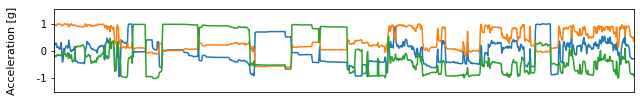

In [6]:
fig = plt.figure(figsize=(width, 1.5))
ax = plt.subplot(1, 1, 1)

ax.plot(time, sig)
plt.axis((0, time[-1], -minmax, minmax))
plt.xlabel('Time', size=font_size)
plt.ylabel('Acceleration [g]', size=font_size)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

ax.set_yticks([-1, 0, 1])
ax.set_yticklabels(["     -1","      0", "      1"])

ax.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig(f"plots/vis_signal.pdf",
            transparent=True)

#### Filterbanks over time

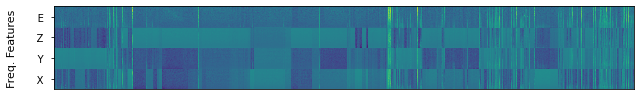

In [7]:
fig = plt.figure(figsize=(width, 1.5))
ax = plt.subplot(1, 1, 1)

ax.pcolor(mel_sig.T)
plt.xlabel('Time', size=font_size)
plt.ylabel('Freq. Features', size=font_size)
ax.grid(False)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

y_ticks = np.arange(20, mel_sig.shape[1], step=40)
ax.set_yticks(y_ticks)
ax.set_yticklabels(["     X ", "     Y ", "    Z ", "     E "])

ax.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig(f"plots/vis_mel.pdf",
            transparent=True)

#### Labels and predictions over time

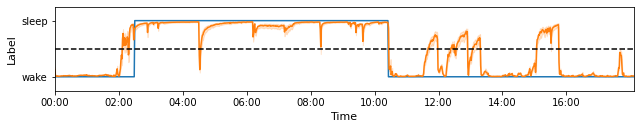

In [8]:
results.loc[:, "time"] = results.index
results = pd.melt(results, id_vars=['time'],
                  value_vars=[f"y_pred_{xx}" for xx in range(10)],
                  var_name='repitition', value_name='score')

fig = plt.figure(figsize=(width, 1.9))
ax = plt.subplot(1, 1, 1)
plt.axis((0, time[-1], -.25, 1.25))

ax = sns.lineplot(x=time, y=labels, ax=ax)
ax = sns.lineplot(x="time", y="score", data=results, ax=ax)
ax.axhline(y=.5, ls="--", c="black")

ax.set_xticks(x_ticks[:-1])
ax.set_xticklabels(x_labels[:-1])

ax.set_yticks([0, 1])
ax.set_yticklabels(["   out", "    in"])
ax.set_yticklabels(["wake", "sleep"])

plt.xlabel('Time', size=font_size)
plt.ylabel('Label', size=font_size)

plt.tight_layout()

plt.savefig(f"plots/vis_combined.pdf",
            transparent=True)

### Total Sleep Time

#### Load data

In [9]:
# Load available subjects
with h5py.File(HDF5_FILE_PATH) as hdf5_file:
    subjects = [subject for subject in hdf5_file.keys() if subject not in EXCLUDED_DATASETS]

# Load the data
X, y, lengths = load_dataset(HDF5_FILE_PATH, subjects, LABEL_DICT, means=means, stds=stds)
X, y = X.float(), y.float()
X, y, lengths = X.to(device), y.to(device), lengths.to(device)
assert X.shape[0] == y.shape[0]
print(f"Loaded {X.shape[0]} sequences with input shape [{X.shape[1]} x {X.shape[2]}] and output shape [{y.shape[1]}]")

Loading data: 100%|██████████| 444/444 [20:32<00:00,  2.78s/it]


Loaded 444 sequences with input shape [1664 x 160] and output shape [1664]


#### Load models and predict sleep/wake status

In [10]:
model = LSTM(INPUT_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, dropout=DROPOUT, batch_first=True)
models_to_test = [model for model in os.listdir(MODEL_BASE_PATH) if f"best_{N_LAYERS}l_LSTM{HID_DIM}_model" in model]

predictions = np.zeros((len(models_to_test), *y.shape))

for ii, model_path in enumerate(tqdm(models_to_test, desc="Predicting models")):
    model_path = os.path.join(MODEL_BASE_PATH, model_path)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    predictions[ii] = model(X, lengths).squeeze().detach().numpy()

Predicting models: 100%|██████████| 10/10 [12:48<00:00, 76.87s/it]


In [11]:
predicted_tst = predictions.mean(axis=0).round().sum(axis=1)
true_tst = y.detach().numpy().sum(axis=1)

In [12]:
tst_data = pd.DataFrame({"Total Sleep Time": true_tst, "Predicted TST": predicted_tst})
tst_data.loc[:, "Difference (Truth - Predicition)"] = tst_data["Total Sleep Time"] - tst_data["Predicted TST"]
tst_data /= 60
tst_data.head()

,Total Sleep Time,Predicted TST,Difference (Truth - Predicition)
0,8.283334,7.416667,0.866667
1,9.500000,9.833333,-0.333333
2,7.250000,8.866667,-1.616667
3,7.633333,8.933333,-1.300000
4,8.583333,7.916667,0.666667


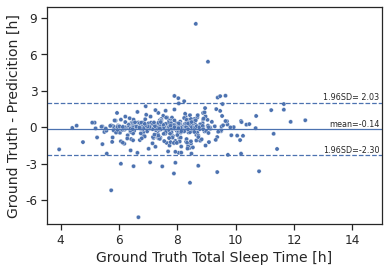

In [13]:
sns.set_theme(style="ticks", font_scale=1.1)

ax = sns.scatterplot(x="Total Sleep Time", y="Difference (Truth - Predicition)", data=tst_data, size=.1, legend=False)

avg = tst_data["Difference (Truth - Predicition)"].mean()
sd = tst_data["Difference (Truth - Predicition)"].std()


ax.set_xlim(right=15)
ax.set_ylim(-8,9.9)

ax.set_yticks([-6,-3,0,3,6,9])
ax.set_yticklabels([-6,-3,0,3,6,9])


ax.axhline(y=avg, lw=1.25)
ax.text(x=13.2, y=avg+.2, s=f"mean={avg:.2f}", size=8)

ax.axhline(y=avg + 1.96*sd, ls="--", lw=1.25)
ax.text(x=13, y=avg + 1.96*sd+.2, s=f"1.96SD= {avg + 1.96*sd:.2f}", size=8)

ax.axhline(y=avg - 1.96*sd, ls="--", lw=1.25)
ax.text(x=13, y=avg - 1.96*sd+.2, s=f"1.96SD={avg - 1.96*sd:.2f}", size=8)


plt.xlabel('Ground Truth Total Sleep Time [h]', size=14)
plt.ylabel('Ground Truth - Predicition [h]', size=14)

ax.figure.savefig(f"plots/tst_bland_altmann.pdf", transparent=True, bbox_inches='tight')

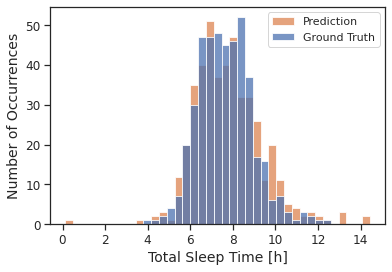

In [14]:
tst_dist = tst_data[["Total Sleep Time", "Predicted TST"]]
tst_dist.columns = ["Ground Truth", "Prediction"]

ax = sns.histplot(data=tst_dist)

plt.xlabel('Total Sleep Time [h]', size=14)
plt.ylabel('Number of Occurrences', size=14)
plt.legend(labels=['Prediction', 'Ground Truth'], fontsize='11')

ax.figure.savefig(f"plots/freq_distribution.pdf", transparent=True, bbox_inches='tight')

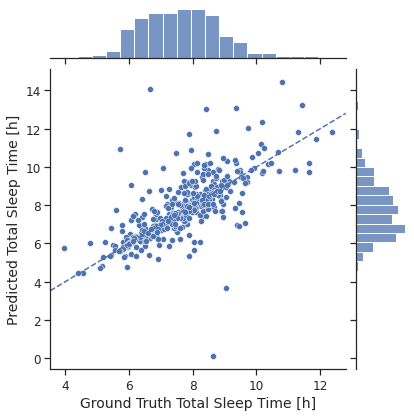

In [15]:
g = sns.jointplot(x="Total Sleep Time", y="Predicted TST", data=tst_data)
g.ax_joint.axline((4,4), slope=1, ls="--")
g.set_axis_labels('Ground Truth Total Sleep Time [h]', 'Predicted Total Sleep Time [h]', size=14)

In [16]:
result_files = {"Counts per minute": "results/exp04_test.csv",
                "Raw acceleration": "results/exp02_test.csv",
                "Frequency features": "results/exp03_test.csv"}

for input_features, file_path in result_files.items():
    print(input_features)
    data = pd.read_csv(file_path)

    data = data[['Fold', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score',
                 'Hidden Dimension', 'Number of Layers', 'Initial Learning Rate',
                 'Model', 'Ellapsed Time']]
    data.loc[:,"# Features in Hidden State"] = data["Hidden Dimension"]


    data = data.loc[data["Model"] != "GLM", :]
    scores = pd.melt(data, id_vars=["Fold", "# Features in Hidden State", 'Number of Layers', 'Model'],
                   value_vars=['F1 Score'],
                   var_name='Metric', value_name='Score')


    agg = scores.groupby(["# Features in Hidden State", 'Number of Layers', 'Metric', 'Model'])["Score"].aggregate(["mean","std"]).reset_index()
    agg.loc[:, "Text"] = agg.apply(lambda x: f'${x["mean"]:.2f}$ $(\pm {x["std"]:.2f})$', axis=1)
    
    for model in ["MLP", "RNN", "LSTM"]:
        print(model)
        print(agg.loc[(agg["Model"] == model), :].pivot(index="Number of Layers", columns="# Features in Hidden State", values="Text").to_latex(escape=False).replace('0.', '.'))

Counts per minute
MLP
\begin{tabular}{llllllll}
\toprule
# Features in Hidden State &                   1  &                   2  &                   4  &                   8  &                   16 &                   32 &                   64 \\
Number of Layers &                      &                      &                      &                      &                      &                      &                      \\
\midrule
1                &  $.54$ $(\pm .38)$ &  $.53$ $(\pm .37)$ &  $.76$ $(\pm .06)$ &  $.76$ $(\pm .06)$ &  $.76$ $(\pm .07)$ &  $.76$ $(\pm .06)$ &  $.76$ $(\pm .07)$ \\
2                &  $.00$ $(\pm .00)$ &  $.24$ $(\pm .39)$ &  $.71$ $(\pm .25)$ &  $.77$ $(\pm .06)$ &  $.77$ $(\pm .06)$ &  $.76$ $(\pm .07)$ &  $.76$ $(\pm .07)$ \\
4                &  $.00$ $(\pm .00)$ &  $.00$ $(\pm .00)$ &  $.31$ $(\pm .40)$ &  $.60$ $(\pm .32)$ &  $.77$ $(\pm .06)$ &  $.77$ $(\pm .06)$ &  $.77$ $(\pm .06)$ \\
\bottomrule
\end{tabular}

RNN
\begin{tabular}{llllllll}
\top